### imports (ML models)

In [ ]:
print ('Submitted By')
print ('UBITname      = karanman')
print ('Person Number = 50290755')

In [1]:
# Importing Packages
import pickle
import gzip
import pandas as pd
import numpy as np 
import os
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from time import time
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import matplotlib.pyplot as plt
import itertools


%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### read mnist data

In [2]:
#load mnist dataset
def one_hot(_y):
    '''
    given a list of numbers,
    returns a one hot encoded version of the numbers,
        example:
            one_hot(np.array([0,1,2,3,4,5,6,7,8,9]))
        returns:
            array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
    '''
    y = np.zeros((_y.shape[0], 10))
    y[np.arange(_y.shape[0]), _y] = 1
    
    return y

# 
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

X_train_r = np.asarray(training_data[0])
_Y_train = np.asarray(training_data[1])
y_train = one_hot(_Y_train)


X_val_r = np.asarray(validation_data[0])
_y_val = np.asarray(validation_data[1])
y_val = one_hot(_y_val)


X_test_r = np.asarray(test_data[0])
_y_test = np.asarray(test_data[1])
y_test = one_hot(_y_test)



### data preprocessing

In [3]:
X_mnist = np.concatenate([X_train_r, X_val_r, X_test_r])
y_mnist = np.concatenate([y_train, y_val, y_test])

In [4]:
# apply standard scaler
def standard_scaler(inner_x):
    return StandardScaler().fit_transform(inner_x)

X_scaled_mnist = standard_scaler(X_mnist)

In [5]:
# separate the train and test sets
X_train_mnist = X_scaled_mnist[:50000]
X_val_mnist = X_scaled_mnist[50000:60000]
X_test_mnist = X_scaled_mnist[60000:]

y_train_mnist = y_mnist[:50000]
y_val_mnist = y_mnist[50000:60000]
y_test_mnist = y_mnist[60000:]

# get the label with the highest predicted prrobability
y_train_mnist = y_train_mnist.argmax(axis=1)
y_val_mnist = y_val_mnist.argmax(axis=1)
y_test_mnist = y_test_mnist.argmax(axis=1)

In [6]:
# print out the datasets' dimensions
print('X_train_mnist shape : {}'.format(X_train_mnist.shape))
print('X_val_mnist shape : {}'.format(X_val_mnist.shape))
print('X_test_mnist shape : {}'.format(X_test_mnist.shape))

X_train_mnist shape : (50000, 784)
X_val_mnist shape : (10000, 784)
X_test_mnist shape : (10000, 784)


In [7]:
# USPS dataset

# path to USPS dataset
path_to_data = "./USPSdata/Numerals/"

# resize to MNIST scale function
def resize_and_scale(img, size, scale):
    img = cv2.resize(img, size)
    return 1 - np.array(img, "float32")/scale

# resize all images
img_list = os.listdir(path_to_data)
sz = (28,28)
validation_usps = []
validation_usps_label = []
for i in range(10):
    label_data = path_to_data + str(i) + '/'
    img_list = os.listdir(label_data)
    for name in img_list:
        if '.png' in name:
            img = cv2.imread(label_data+name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = resize_and_scale(img, sz, 255)
            validation_usps.append(resized_img.flatten())
            validation_usps_label.append(i)

In [8]:
# convert to numpy array and even batch sizes
validation_usps = np.array(validation_usps)
validation_usps = validation_usps[:-3]
print(validation_usps.shape)
validation_usps_label= np.array(validation_usps_label)
validation_usps_label = validation_usps_label[:-3]
print(validation_usps_label.shape)
validation_usps_label_one_hot = one_hot(validation_usps_label)

(19996, 784)
(19996,)


### confusion matrix helper function

In [9]:
# confusion matrix method
def plot_confusion_matrix(cm, classes, cm_path, model='Random Forest',
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("{} Normalized confusion matrix".format(model))
    else:
        print('{} Confusion matrix'.format(model))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.figure()



### Logistic Regression

In [10]:
def logistic_regression(dataset):
    X_train, y_train, X_val, y_val, X_test, y_test, X_usps, y_usps = dataset

    def softmax(x):
        e = np.exp(x - np.max(x))  # this prevent overflow
        if e.ndim == 1:
            return e / np.sum(e, axis=0)
        else:  
            return e / np.array([np.sum(e, axis=1)]).T  # ndim = 2


    class LogisticRegression(object):
        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.W = np.zeros((x.shape[1], y.shape[1]))  # initialize Weights 0
            self.b = np.zeros(y.shape[1])          # initialize bias 0
        
        def fit(self, lr=0.1):

            h = softmax(np.dot(self.x, self.W) + self.b)

            d_y = self.y - h
            
            self.W += lr * np.dot(self.x.T, d_y)
            self.b += lr * np.mean(d_y, axis=0)

        def loss(self):
            h = softmax(np.dot(self.x, self.W) + self.b)
            y = self.y
            
            return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
        
        def predict(self, x):
            return softmax(np.dot(x, self.W) + self.b)


    ## hyper-parameters
    ### learning rates
    lrs = [0.01, 0.001]
    ### number of iterations
    n_iters = [5, 20, 50, 100, 250]
    
    ## limited grid of hyper-parameters
    ### learning rates
    lrs = [0.01, 0.001]
    ### number of iterations
    n_iters = [5,20,50,100,250]


    def train_logr_model(lr, n_iter, usps=False):


        print('\n--Hyperparameters--')
        print('learning rate : {}'.format(lr))
        print('no of iterations : {}'.format(n_iter))
        
        # standardize by dividing with 255
        model = LogisticRegression(X_train/255, y_train)
        for i in range(n_iter):
            model.fit(lr=lr)

        print('loss : {}'.format(model.loss()))
        
        train_preds = model.predict(X_train)
        acc_train = accuracy_score(y_train, (train_preds>0.5).astype(int))
        
        val_preds = model.predict(X_val)
        acc_val = accuracy_score(y_val, (val_preds>0.5).astype(int))
        
        test_preds = model.predict(X_test)
        acc_test = accuracy_score(y_test, (test_preds>0.5).astype(int))
        
        print('training accuracy : {}'.format(acc_train))
        print('validation accuracy : {}'.format(acc_val))
        print('test accuracy : {}'.format(acc_test))
        if usps:
            usps_preds = model.predict(X_usps)
            acc_usps = accuracy_score(y_usps, (usps_preds>0.5).astype(int))
            return (acc_train, acc_val, acc_test, acc_usps), (test_preds, usps_preds)
        
        return (acc_train, acc_val, acc_test), val_preds


    scores_df = pd.DataFrame()
    for lr in lrs:
        for n_iter in n_iters:
            (acc_train, acc_val, acc_test), val_preds = train_logr_model(lr, n_iter)
            scores = pd.DataFrame([acc_val], index=['acc'], columns=[(lr, n_iter)]).T
            scores_df = pd.concat([scores_df, scores])

    best_params = scores_df['acc'].idxmax()
    lr = best_params[0]
    n_iter = best_params[1]

    print('\n--Training with best hyper-parameters--\n')

    (acc_train, acc_val, acc_test, acc_usps), (test_preds, usps_preds) = train_logr_model(lr, n_iter, usps=True)

    print('training accuracy : {}'.format(acc_train))
    print('validation accuracy : {}'.format(acc_val))
    print('test accuracy : {}'.format(acc_test))
    print('usps accuracy : {}'.format(acc_usps))
    
    return test_preds, usps_preds
    

In [11]:
dataset = (X_train_r, y_train, X_val_r, y_val, X_test_r, y_test, validation_usps, validation_usps_label_one_hot)
y_preds_logr_mnist, y_preds_logr_usps = logistic_regression(dataset)


--Hyperparameters--
learning rate : 0.01
no of iterations : 5
loss : 0.3205976055871282
training accuracy : 0.66776
validation accuracy : 0.6977
test accuracy : 0.6783

--Hyperparameters--
learning rate : 0.01
no of iterations : 20
loss : 0.3078842653639733
training accuracy : 0.70818
validation accuracy : 0.7356
test accuracy : 0.7166

--Hyperparameters--
learning rate : 0.01
no of iterations : 50
loss : 0.2851105304115011
training accuracy : 0.73728
validation accuracy : 0.7593
test accuracy : 0.7475

--Hyperparameters--
learning rate : 0.01
no of iterations : 100
loss : 0.253588326114912
training accuracy : 0.76176
validation accuracy : 0.7809
test accuracy : 0.7749

--Hyperparameters--
learning rate : 0.01
no of iterations : 250
loss : 0.19344082606259436


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in greater


training accuracy : 0.5394
validation accuracy : 0.651
test accuracy : 0.5924

--Hyperparameters--
learning rate : 0.001
no of iterations : 5
loss : 0.32462876703554855
training accuracy : 0.07194
validation accuracy : 0.0737
test accuracy : 0.0697

--Hyperparameters--
learning rate : 0.001
no of iterations : 20
loss : 0.32327484852527955
training accuracy : 0.58054
validation accuracy : 0.6141
test accuracy : 0.5981

--Hyperparameters--
learning rate : 0.001
no of iterations : 50
loss : 0.3206044943895107
training accuracy : 0.66982
validation accuracy : 0.6998
test accuracy : 0.6798

--Hyperparameters--
learning rate : 0.001
no of iterations : 100
loss : 0.31625694034862106
training accuracy : 0.68924
validation accuracy : 0.7206
test accuracy : 0.6987

--Hyperparameters--
learning rate : 0.001
no of iterations : 250
loss : 0.3038856067967561
training accuracy : 0.71624
validation accuracy : 0.7411
test accuracy : 0.7256

--Training with best hyper-parameters--


--Hyperparameters--


## convert one-hot encoded values to numbers

In [12]:
print(y_preds_logr_mnist.shape)
y_preds_logr_mnist = y_preds_logr_mnist.argmax(axis=1)
print(y_preds_logr_mnist.shape)

(10000, 10)
(10000,)


In [13]:
print(y_preds_logr_usps.shape)
y_preds_logr_usps = y_preds_logr_usps.argmax(axis=1)
print(y_preds_logr_usps.shape)

(19996, 10)
(19996,)


In [14]:
# get unique labels
classes = np.unique(y_test_mnist)

# compute confusion matrix for mnist
cm_mnist = confusion_matrix(y_test_mnist, y_preds_logr_mnist, labels=classes)

# compute confusion matrix for usps
cm_usps = confusion_matrix(validation_usps_label, y_preds_logr_usps, labels=classes)

Random Forest Confusion matrix


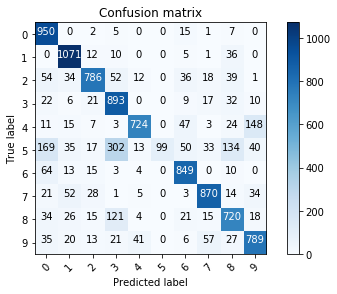

<Figure size 432x288 with 0 Axes>

In [15]:
# plot mnist confusion matrix
plot_confusion_matrix(cm_mnist, classes, model ='Logistic Regression', cm_path=None)

Random Forest Confusion matrix


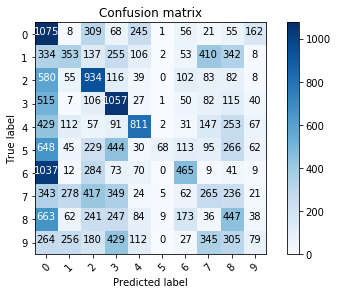

<Figure size 432x288 with 0 Axes>

In [16]:
# plot usps confusion matrix
plot_confusion_matrix(cm_usps, classes, model ='Logistic Regression', cm_path=None)

### Random Forest 

In [17]:
# grid of hyperparameters
ranf_params = {'n_estimators' :[10, 50, 100],
'max_features' :['auto', 'sqrt', 'log2'],
'max_depth' :[6, 7, 8, None],
'n_jobs' : [-1]}                    

In [18]:
# # limited grid of hyperparameters
# ranf_params = {'n_estimators' :[10, 50],
# 'max_features' :['auto'],
# 'max_depth' :[None],
# 'n_jobs' : [-1]} 

In [19]:
# model hyperparameters
ranf_kwarg = {'n_estimators' :10,
'max_features' :'auto',
'max_depth' :None,
'n_jobs' : -1}   

In [20]:
# predefined validation data to pass to grid search for hyperparameter tuning
ps = PredefinedSplit(test_fold=y_val_mnist)

In [21]:
# initialize random forest model
ranf = RandomForestClassifier()

In [22]:
# initialize grid search on the grid of hyperparameters
gsearch1 = GridSearchCV(estimator=ranf,
                        param_grid=ranf_params,
                        scoring='accuracy', n_jobs=-1, cv=ps, verbose=1)
#
# fit the grid search using the training data
gsearch1.fit(X_train_mnist, y_train_mnist)



Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  7.1min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([3, 8, ..., 6, 8])),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [6, 7, 8, None], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [23]:
# results of hyperparameter tuning on validation data (cross validation)
cv_results = gsearch1.cv_results_
scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')[['params', 'mean_test_score']]
print('grid search results : \n {}'.format(scores_df))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

grid search results : 
                                                params  mean_test_score
32  {'max_depth': None, 'max_features': 'sqrt', 'n...           0.9493
29  {'max_depth': None, 'max_features': 'auto', 'n...           0.9479
35  {'max_depth': None, 'max_features': 'log2', 'n...           0.9464
31  {'max_depth': None, 'max_features': 'sqrt', 'n...           0.9462
28  {'max_depth': None, 'max_features': 'auto', 'n...           0.9447
34  {'max_depth': None, 'max_features': 'log2', 'n...           0.9397
20  {'max_depth': 8, 'max_features': 'auto', 'n_es...           0.9233
23  {'max_depth': 8, 'max_features': 'sqrt', 'n_es...           0.9212
22  {'max_depth': 8, 'max_features': 'sqrt', 'n_es...           0.9191
19  {'max_depth': 8, 'max_features': 'auto', 'n_es...           0.9176
30  {'max_depth': None, 'max_features': 'sqrt', 'n...           0.9125
26  {'max_depth': 8, 'max_features': 'log2', 'n_es...           0.9120
27  {'max_depth': None, 'max_features': 'auto', 'n...

In [24]:
# set the model kwargs to the grid-searched optimum
print('Best model kwargs: %s', gsearch1.best_params_)
for kwarg in gsearch1.best_params_:
    ranf_kwarg[kwarg] = gsearch1.best_params_[kwarg]

    
ranf = eval(str(ranf))

# set model parameters to grid-searched optimum
ranf.set_params(**ranf_kwarg)

Best model kwargs: %s {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
# train random forest
ranf.fit(X_train_mnist, y_train_mnist)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
# predict on mnist test set
y_preds_ranf_mnist = ranf.predict(X_test_mnist)

# compute accuracy on mnist test set
acc_mnist = accuracy_score(y_preds_ranf_mnist, y_test_mnist)

# predict on usps test set
y_preds_ranf_usps = ranf.predict(validation_usps)

# compute accuracy on usps test set
acc_usps = accuracy_score(validation_usps_label, y_preds_ranf_usps)

# print out test scores
print('Accuracy on MNIST test set : {}'.format(acc_mnist))

print('Accuracy on USPS dataset : {}'.format(acc_usps))

Accuracy on MNIST test set : 0.968
Accuracy on USPS dataset : 0.10097019403880776


In [27]:
# get unique labels
classes = np.unique(y_test_mnist)

# compute confusion matrix for mnist
cm_mnist = confusion_matrix(y_test_mnist, y_preds_ranf_mnist, labels=classes)

# compute confusion matrix for usps
cm_usps = confusion_matrix(validation_usps_label, y_preds_ranf_usps, labels=classes)

Random Forest Confusion matrix


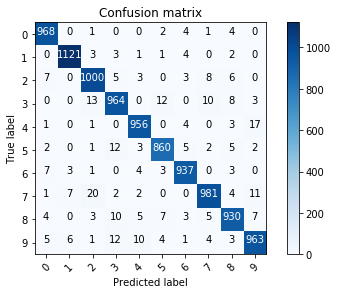

<Figure size 432x288 with 0 Axes>

In [28]:
# plot mnist confusion matrix
plot_confusion_matrix(cm_mnist, classes, model='Random Forest', cm_path=None)

Random Forest Confusion matrix


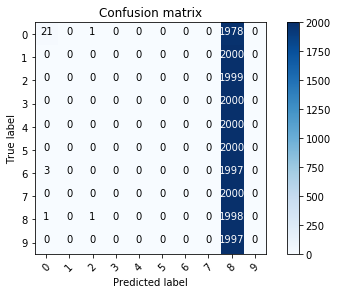

<Figure size 432x288 with 0 Axes>

In [29]:
# plot usps confusion matrix
plot_confusion_matrix(cm_usps, classes, model='Random Forest', cm_path=None)

### SVC PCA

In [30]:
# no of PCA componets
n_components = 16


# initialize PCA for mnist
pca_mnist = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_mnist)

# initialize PCA for usps
pca_usps = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(validation_usps)



# pca on mnist
X_mnist_pca = pca_mnist.transform(X_mnist)

# pca on usps
X_usps_pca = pca_usps.transform(validation_usps)

# separate the train and test sets
X_train_mnist_pca = X_mnist_pca[:50000]
X_val_mnist_pca = X_mnist_pca[50000:60000]
X_test_mnist_pca = X_mnist_pca[60000:]

0.5953046282043643

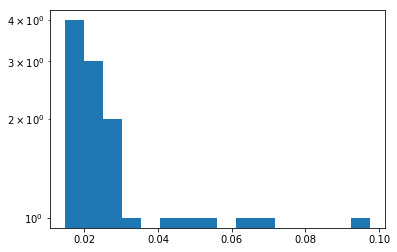

In [31]:
# mnist explained variance
plt.hist(pca_mnist.explained_variance_ratio_, bins=n_components, log=True)
pca_mnist.explained_variance_ratio_.sum()

0.37983203

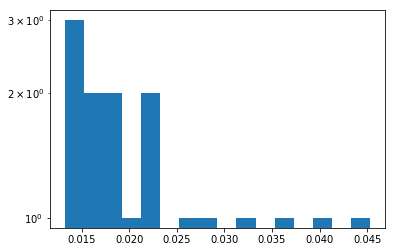

In [32]:
# usps explained variance
plt.hist(pca_usps.explained_variance_ratio_, bins=n_components, log=True)
pca_usps.explained_variance_ratio_.sum()

In [33]:
# grid of hyperparameters
svc_params = {'kernel' : ['rbf', 'linear', 'poly'],
'C' : [1e0, 1e1, 1e2, 1e3],
'gamma' : [1, 10, 100]
               }

In [34]:
# # limited grid of hyperparameters
# svc_params = {'kernel' : ['linear'],
# 'C' : [1e0, 1e1],
# 'gamma' : [1]
#                }

In [35]:
# svc hyperparameters
svc_kwarg = {'kernel' : 'linear',
'C' : 1e0,
'gamma' : 1
               }

In [36]:
# initialize support vector machine classifier
svc = SVC()

In [37]:
# predefined validation data to pass to grid search for hyperparameter tuning
ps = PredefinedSplit(test_fold=y_val_mnist)

In [38]:
# initialize grid search
gsearch1 = GridSearchCV(estimator=svc,
                        param_grid=svc_params,
                        scoring='accuracy', n_jobs=-1, cv=ps, verbose=1)
#
# fit the grid search using the training data
gsearch1.fit(X_train_mnist_pca, y_train_mnist)



Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 75.9min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([3, 8, ..., 6, 8])),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ['rbf', 'linear', 'poly'], 'C': [1.0, 10.0, 100.0, 1000.0], 'gamma': [1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [39]:
# get results and display
cv_results = gsearch1.cv_results_
scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')[['params', 'mean_test_score']]
print('grid search results : \n {}'.format(scores_df))

grid search results : 
                                              params  mean_test_score
17      {'C': 10.0, 'gamma': 100, 'kernel': 'poly'}           0.9397
32     {'C': 1000.0, 'gamma': 10, 'kernel': 'poly'}           0.9397
29      {'C': 1000.0, 'gamma': 1, 'kernel': 'poly'}           0.9397
26     {'C': 100.0, 'gamma': 100, 'kernel': 'poly'}           0.9397
23      {'C': 100.0, 'gamma': 10, 'kernel': 'poly'}           0.9397
20       {'C': 100.0, 'gamma': 1, 'kernel': 'poly'}           0.9397
14       {'C': 10.0, 'gamma': 10, 'kernel': 'poly'}           0.9397
11        {'C': 10.0, 'gamma': 1, 'kernel': 'poly'}           0.9397
35    {'C': 1000.0, 'gamma': 100, 'kernel': 'poly'}           0.9397
2          {'C': 1.0, 'gamma': 1, 'kernel': 'poly'}           0.9397
5         {'C': 1.0, 'gamma': 10, 'kernel': 'poly'}           0.9397
8        {'C': 1.0, 'gamma': 100, 'kernel': 'poly'}           0.9397
7      {'C': 1.0, 'gamma': 100, 'kernel': 'linear'}           0.8877
1        {

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

In [40]:
# set the model kwargs to the grid-searched optimum
print('Best model kwargs: %s', gsearch1.best_params_)
for kwarg in gsearch1.best_params_:
    svc_kwarg[kwarg] = gsearch1.best_params_[kwarg]
    
svc = eval(str(svc))

# set model parameters to grid-searched optimum
svc.set_params(**svc_kwarg)

Best model kwargs: %s {'C': 1.0, 'gamma': 1, 'kernel': 'poly'}


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
# train SVC
svc.fit(X_train_mnist_pca, y_train_mnist)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
# predict on mnist
y_preds_svc_mnist = svc.predict(X_test_mnist_pca)

# predict on usps
y_preds_svc_usps = svc.predict(X_usps_pca)

# compute accuracy for mnist
acc_mnist = svc.score(X_test_mnist_pca, y_test_mnist)

# compute accuracy for usps
acc_usps = accuracy_score(validation_usps_label, y_preds_svc_usps)

In [43]:
# display results
print('Accuracy on MNIST test set : {}'.format(acc_mnist))

print('Accuracy on USPS test set : {}'.format(acc_usps))   

Accuracy on MNIST test set : 0.9565
Accuracy on USPS test set : 0.07141428285657131


In [44]:
# get the labels
classes = np.unique(y_test_mnist)

# compute mnist confusion matrix
cm_mnist = confusion_matrix(y_test_mnist, y_preds_svc_mnist, labels=classes)

# compute usps confusion matrix
cm_usps = confusion_matrix(validation_usps_label, y_preds_svc_usps, labels=classes)


Random Forest Confusion matrix


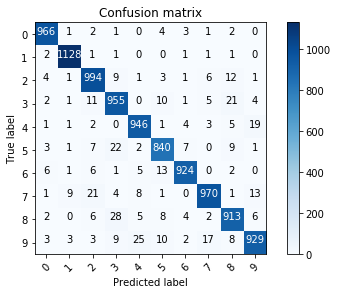

<Figure size 432x288 with 0 Axes>

In [45]:
# plot mnist confusion matrix
plot_confusion_matrix(cm_mnist, classes, model='Support Vector Classifier', cm_path=None)

Random Forest Confusion matrix


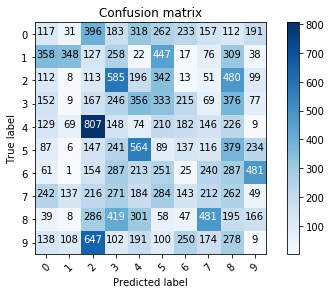

<Figure size 432x288 with 0 Axes>

In [46]:
# plot usps confusion matrix
plot_confusion_matrix(cm_usps, classes, model='Support Vector Classifier', cm_path=None)

### Neural Network

#### Imports (Neural Network)

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Processing...
Done!
Labels:  tensor([1, 1, 7, 0])
Batch shape:  torch.Size([4, 1, 28, 28])


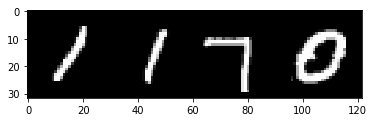

In [48]:

# initialize transform (converting to pytorch tensor)
transform = transforms.ToTensor()

# initialize hyperparameter grids
lrs_grid = [1e-6, 1e-4, 1e-3]
neurons_grid = [16, 32, 48, 64, 128, 256]

# # limited grid of hyperparams for testing
# lrs_grid = [1e-6, 1e-4]
# neurons_grid = [16]

# batch size
BATCH_SIZE = 4

# initialize pytorch datasets
trainset_mnist = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

validation_mnist = X_val_mnist.reshape(-1, 1, 28, 28)
valset_mnist = torch.utils.data.TensorDataset(torch.from_numpy(validation_mnist), torch.Tensor(y_val_mnist))
valloader_mnist = torch.utils.data.DataLoader(valset_mnist, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

testset_mnist = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=transform)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

validation_usps = validation_usps.reshape(-1, 1, 28, 28)
testset_usps = torch.utils.data.TensorDataset(torch.from_numpy(validation_usps), torch.Tensor(validation_usps_label))
testloader_usps = torch.utils.data.DataLoader(testset_usps, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# visualize mnist batch
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

dataiter = iter(trainloader_mnist)
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)


# define the neural network
class SequentialMNIST(nn.Module):
    def __init__(self, no_neurons):
        super(SequentialMNIST, self).__init__()
        self.linear1 = nn.Linear(28*28, no_neurons)
        self.linear2 = nn.Linear(no_neurons, 10)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x.view(BATCH_SIZE, -1)))
        y_pred = self.linear2(h_relu)
        return y_pred

# define the train function for mnist
def train_mnist(model, trainloader_mnist, criterion, optimizer, n_epochs=2):
    for t in range(n_epochs):
        for i, data in enumerate(trainloader_mnist):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)

            # TODO: why?
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels) # Compute the loss
            loss.backward() # Compute the gradient for each variable
            optimizer.step() # Update the weights according to the computed gradient

            if not i % 2000:
                print(t, i, loss.data[0])
    
    return model

# define the test function for mnist
def val_mnist(model, val_mnist):
    outGT = torch.FloatTensor()
    outPRED = torch.FloatTensor()
    
    for i, data in enumerate(valloader_mnist):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)

        outGT = torch.cat((outGT, labels), 0)

        outPRED = torch.cat((outPRED, outputs), 0)
        
    outPRED = outPRED.data.max(dim=1)[1]
        
    return outPRED.numpy()

# define the test function for mnist
def test_mnist(model, testloader_mnist):
    outGT = torch.LongTensor()
    outPRED = torch.FloatTensor()
    
    for i, data in enumerate(testloader_mnist):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)

        outGT = torch.cat((outGT, labels), 0)

        outPRED = torch.cat((outPRED, outputs), 0)
        
    outPRED = outPRED.data.max(dim=1)[1]
        
    return outPRED.numpy()

# define the test function for usps
def test_usps(model, testloader_usps):
    outGT = torch.FloatTensor()
    outPRED = torch.FloatTensor()
    
    for i, data in enumerate(testloader_usps):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)

        outGT = torch.cat((outGT, labels), 0)

        outPRED = torch.cat((outPRED, outputs), 0)
        
    outPRED = outPRED.data.max(dim=1)[1]
        
    return outPRED.numpy()


In [49]:
# loss function
criterion = nn.CrossEntropyLoss()

# initialize scores dataframe
scores_df = pd.DataFrame()

# loop throuth hyperparameters
for neurons in neurons_grid:
    for lr in lrs_grid:
        
        # initialize model
        model = SequentialMNIST(neurons)
        
        # initialize optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # train model
        model = train_mnist(model, trainloader_mnist, criterion, optimizer, n_epochs=1)
        
        # predict on the mnist validation set
        y_preds_nn_mnist = val_mnist(model, valloader_mnist)
        
        # predict on the usps validation set
        y_preds_nn_usps = test_usps(model, testloader_usps)
        
        # compute accuracy
        acc_mnist = accuracy_score(y_val_mnist, y_preds_nn_mnist)

        acc_usps = accuracy_score(validation_usps_label, y_preds_nn_usps)
        
        # load scores into dataframe
        scores = pd.DataFrame([acc_mnist, acc_usps], index=['acc_mnist', 'acc_usps'], columns=[(neurons, lr)]).T
        scores_df = pd.concat([scores_df, scores])
        

        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0 0 tensor(2.3665)
0 2000 tensor(2.2214)
0 4000 tensor(2.3215)
0 6000 tensor(2.2373)
0 8000 tensor(2.2820)
0 10000 tensor(2.3235)
0 12000 tensor(2.2518)
0 14000 tensor(2.2170)
0 0 tensor(2.2343)
0 2000 tensor(0.7624)
0 4000 tensor(0.5568)
0 6000 tensor(0.4905)
0 8000 tensor(1.2903)
0 10000 tensor(0.5763)
0 12000 tensor(0.2722)
0 14000 tensor(0.1983)
0 0 tensor(2.2973)
0 2000 tensor(0.0509)
0 4000 tensor(0.7249)
0 6000 tensor(0.1010)
0 8000 tensor(1.8339)
0 10000 tensor(0.0355)
0 12000 tensor(0.6033)
0 14000 tensor(0.0123)
0 0 tensor(2.2921)
0 2000 tensor(2.3209)
0 4000 tensor(2.2839)
0 6000 tensor(2.2142)
0 8000 tensor(2.2111)
0 10000 tensor(2.1733)
0 12000 tensor(2.2260)
0 14000 tensor(2.2406)
0 0 tensor(2.2489)
0 2000 tensor(0.6901)
0 4000 tensor(0.3979)
0 6000 tensor(0.4267)
0 8000 tensor(0.0844)
0 10000 tensor(0.3866)
0 12000 tensor(0.0985)
0 14000 tensor(1.2719)
0 0 tensor(2.3424)
0 2000 tensor(0.2395)
0 4000 tensor(0.1394)
0 6000 tensor(0.0802)
0 8000 tensor(0.2944)
0 10000 tenso

In [50]:
# loop through all scores
scores_df_str = scores_df.copy(deep=True)
scores_df_str.index = scores_df_str.index.map(str)
for i in range(scores_df.shape[0]):
    params = scores_df.index.values[i]
    neurons = params[0]
    lr = params[1]
    
    params_str = scores_df_str.index.values[i]
    acc_mnist= scores_df_str.loc[params_str, 'acc_mnist']
    acc_usps= scores_df_str.loc[params_str, 'acc_usps']
    print('Accuracy with neurons : {} and learning rate {} \n mnist : {} : usps : {}'.format(neurons, lr, acc_mnist, acc_usps))

Accuracy with neurons : 16 and learning rate 1e-06 
 mnist : 0.1751 : usps : 0.13342668533706742
Accuracy with neurons : 16 and learning rate 0.0001 
 mnist : 0.8281 : usps : 0.33296659331866374
Accuracy with neurons : 16 and learning rate 0.001 
 mnist : 0.7566 : usps : 0.38157631526305263
Accuracy with neurons : 32 and learning rate 1e-06 
 mnist : 0.4521 : usps : 0.16168233646729346
Accuracy with neurons : 32 and learning rate 0.0001 
 mnist : 0.8262 : usps : 0.35302060412082414
Accuracy with neurons : 32 and learning rate 0.001 
 mnist : 0.8367 : usps : 0.40023004600920187
Accuracy with neurons : 48 and learning rate 1e-06 
 mnist : 0.4879 : usps : 0.17028405681136227
Accuracy with neurons : 48 and learning rate 0.0001 
 mnist : 0.8503 : usps : 0.35342068413682737
Accuracy with neurons : 48 and learning rate 0.001 
 mnist : 0.8697 : usps : 0.41858371674334865
Accuracy with neurons : 64 and learning rate 1e-06 
 mnist : 0.5436 : usps : 0.1818863772754551
Accuracy with neurons : 64 a

In [51]:
best_params = scores_df['acc_mnist'].idxmax()

neurons = best_params[0]
lr = best_params[1]

print('\n--Training with best hyper-parameters--\n')

# initialize neural network
model = SequentialMNIST(neurons)

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# train the model
model = train_mnist(model, trainloader_mnist, criterion, optimizer, n_epochs=1)


--Training with best hyper-parameters--



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0 0 tensor(2.1998)
0 2000 tensor(0.2066)
0 4000 tensor(0.0422)
0 6000 tensor(0.1642)
0 8000 tensor(0.8934)
0 10000 tensor(0.0113)
0 12000 tensor(0.2810)
0 14000 tensor(0.0338)


In [52]:
# mnist test set predictions
y_preds_nn_mnist = test_mnist(model, testloader_mnist)

# mnist test set accuracy
acc_mnist = accuracy_score(y_test_mnist, y_preds_nn_mnist)

# usps test set predictions
y_preds_nn_usps = test_usps(model, testloader_usps)

# usps test set accuracy
acc_usps = accuracy_score(validation_usps_label, y_preds_nn_usps)

In [53]:
# print out results
print('Accuracy on test set : {}'.format(acc_mnist))

print('Accuracy on USPS dataset : {}'.format(acc_usps))

Accuracy on test set : 0.9654
Accuracy on USPS dataset : 0.45424084816963395


In [54]:
# get the labels
classes = np.unique(y_test_mnist)

# mnist confusion matrix
cm_mnist = confusion_matrix(y_test_mnist, y_preds_svc_mnist, labels=classes)

# usps confusion matrix
cm_usps = confusion_matrix(validation_usps_label, y_preds_nn_usps, labels=classes)

Random Forest Confusion matrix


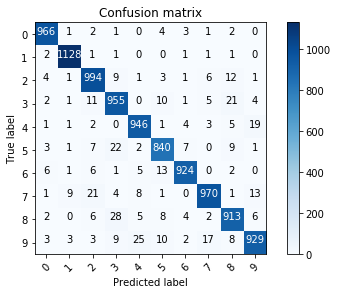

<Figure size 432x288 with 0 Axes>

In [55]:
# plot mnist confusion matrix
plot_confusion_matrix(cm_mnist, classes, model='Neural Network', cm_path=None)

Random Forest Confusion matrix


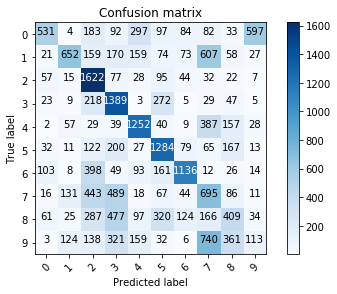

<Figure size 432x288 with 0 Axes>

In [56]:
# plot usps confusion matrix
plot_confusion_matrix(cm_usps, classes, model='Neural Network', cm_path=None)

### Ensemble classifier (majority voting)

In [57]:
# merge labels and all model predictions for mnist
y_pred_mnist = pd.DataFrame({'label' : y_test_mnist})

y_pred_mnist['ranf_mnist'] = y_preds_ranf_mnist.astype(int)
y_pred_mnist['svc_mnist'] = y_preds_svc_mnist.astype(int)
### For logistic regression
y_pred_mnist['logr'] = y_preds_logr_mnist.astype(int)
y_pred_mnist['nn_mnist'] = y_preds_nn_mnist.astype(int)

y_pred_mnist['prediction_mnist'] = 0
y_pred_mnist['prediction_mnist'] = y_pred_mnist.iloc[:, 1:3].mode(axis=1)
y_pred_mnist['prediction_mnist'] = y_pred_mnist['prediction_mnist'].astype(int)


In [58]:
# merge labels and all model predictions for usps
y_pred_usps = pd.DataFrame({'label_usps' : validation_usps_label})

y_pred_usps['ranf_usps'] = y_preds_ranf_usps.astype(int)
y_pred_usps['svc_usps'] = y_preds_svc_usps.astype(int)
### For logistic regression
y_pred_usps['logr_usps'] = y_preds_logr_usps.astype(int)
y_pred_usps['nn_usps'] = y_preds_nn_usps.astype(int)

y_pred_usps['prediction_usps'] = 0
y_pred_usps['prediction_usps'] = y_pred_usps.iloc[:, 1:3].mode(axis=1)
y_pred_usps['prediction_usps'] = y_pred_usps['prediction_usps'].astype(int)

In [59]:
# mnist accuracy
acc_mnist = accuracy_score(y_test_mnist, y_pred_mnist['prediction_mnist'])

print('Accuracy of ensemble on MNIST test set : {}'.format(acc_mnist))

Accuracy of ensemble on MNIST test set : 0.9594


In [60]:
# usps accuracy
acc_usps = accuracy_score(validation_usps_label, y_pred_usps['prediction_usps'])

print('Accuracy of ensemble on USPS dataset : {}'.format(acc_usps))

Accuracy of ensemble on USPS dataset : 0.08021604320864173


In [61]:
# get the labels
classes = np.unique(y_test_mnist)

# mnist confusion matrix
cm_mnist = confusion_matrix(y_test_mnist, y_pred_mnist['prediction_mnist'], labels=classes)

Random Forest Confusion matrix


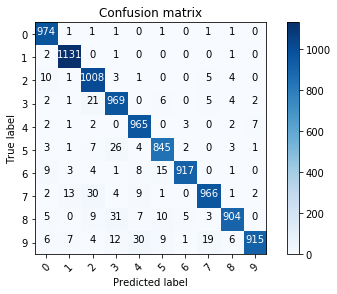

<Figure size 432x288 with 0 Axes>

In [62]:
# plot mnist confusion matrix
plot_confusion_matrix(cm_mnist, classes, model='Ensemble Classifier', cm_path=None)

In [63]:
# usps confusion matrix
cm_usps = confusion_matrix(validation_usps_label, y_pred_usps['prediction_usps'], labels=classes)

Random Forest Confusion matrix


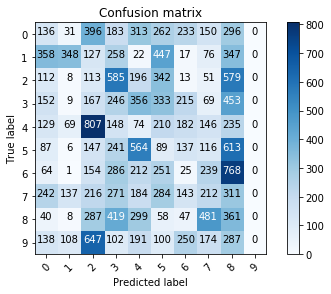

<Figure size 432x288 with 0 Axes>

In [64]:
# plot usps confusion matrix
plot_confusion_matrix(cm_usps, classes, model='Ensemble Classifier', cm_path=None)